# PDR Tutorial
> <br>
> A PDR Algorithm Tutorial for Wrist-Worn IMU<br>
> <br>
> Contribute by NCKU Point Lab <br>
> <br>

## Enviroment Set Up

In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt

from scipy.signal import butter, lfilter, savgol_filter, find_peaks
from vqf import PyVQF
import ahrs
from squaternion import Quaternion
import yaml
from scipy import stats

## Read Data
> <br>
> Format: 'GPST', 'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz' <br>
> <br>
> Choose the config file <br>
> <br>

In [2]:
root = tk.Tk()
root.wm_attributes('-topmost', 1)
root.withdraw()
filename = filedialog.askopenfilename()
with open(filename, 'r') as file:
    config = yaml.safe_load(file)
df_data = pd.read_csv(config['DATA_Path']['data_folder'] + config['DATA_Path']['input_name'], sep=",",header=0)

data_raw = df_data[['GPST', 'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']].to_numpy().transpose()

## Parameter
frequence = config['PDR_Parameter']['frequence']
g = config['PDR_Parameter']['g']
user_height = config['PDR_Parameter']['user_height']
init_heading = config['PDR_Parameter']['init_heading']
init_E = config['PDR_Parameter']['init_E']
init_N = config['PDR_Parameter']['init_N']
df_data

,GPST,Ax,Ay,Az,Gx,Gy,Gz
0,390884.272,-1.833844,-9.669357,1.412158,-0.042,-0.014,-0.027
1,390884.312,-1.716164,-9.551677,1.363124,-0.018,-0.058,0.003
2,390884.352,-1.618097,-9.532064,1.323898,-0.016,-0.115,0.044
3,390884.392,-1.500417,-9.639937,1.294478,-0.018,-0.150,0.031
4,390884.432,-1.353318,-9.718390,1.363124,-0.018,-0.104,0.027
...,...,...,...,...,...,...,...
28305,392015.345,-0.490333,-9.757617,0.372653,0.008,-0.034,-0.006
28306,392015.385,-0.441299,-9.796843,0.441299,-0.005,-0.008,-0.006
28307,392015.425,-0.490333,-9.885103,0.460913,-0.010,0.036,0.000
28308,392015.464,-0.568786,-9.826263,0.500139,-0.004,-0.012,-0.015


## Preporcessing
### Plot Data

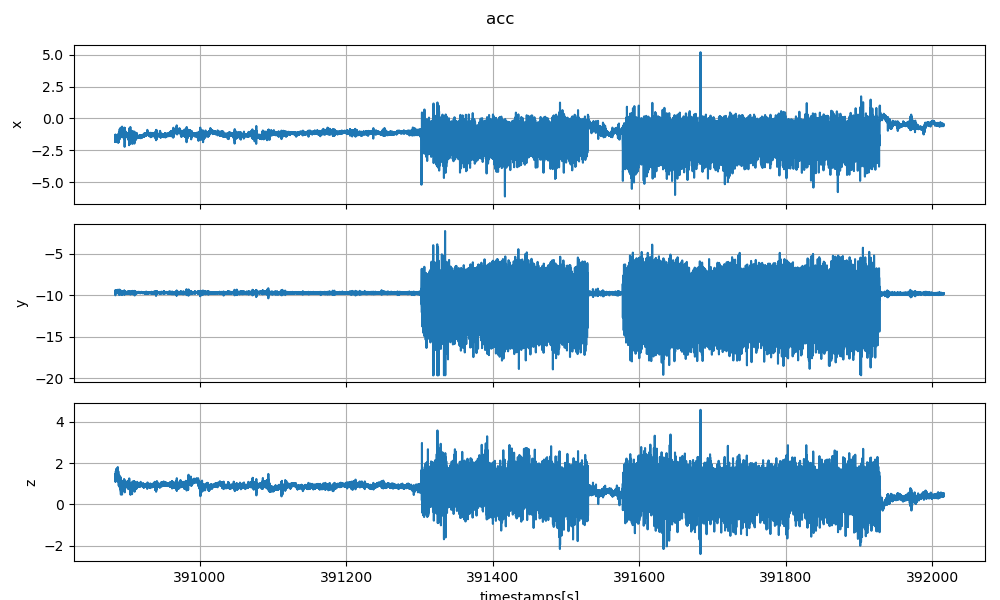

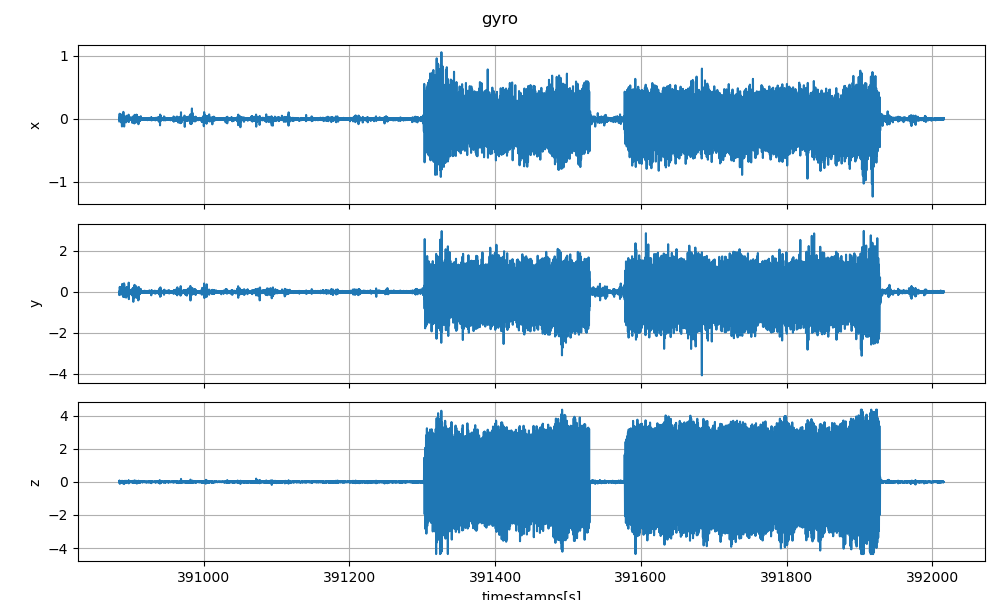

In [3]:
def plot_signal(time, data, title_name):
  fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10, 6))
  ax1.plot(time, data[0])
  ax1.set_ylabel('x')
  ax1.grid(True)
  ax2.plot(time, data[1])
  ax2.set_ylabel('y')
  ax2.grid(True)
  ax3.plot(time, data[2])
  ax3.set_ylabel('z')
  ax3.grid(True)
  plt.suptitle(title_name)
  plt.tight_layout()
  plt.xlabel("timestamps[s]")
plot_signal(data_raw[0], data_raw[1:4], 'acc')
plot_signal(data_raw[0], data_raw[4:7], 'gyro')

### Calibration

In [4]:
def gyr_calibration(gyr_data, index, threshold, frequence, static_time):
    calibrated_gyr_data = np.empty((index, 3))
    gyro_std = np.ones(index) * 100
    static_gyr_datax = []
    static_gyr_datay = []
    static_gyr_dataz = []
    for i in range(0, frequence * static_time, frequence):
        gyro_std[i] = np.std(np.linalg.norm(gyr_data[i:i + frequence, :], axis = 1))
        if gyro_std[i] < threshold:
            static_gyr_datax = np.append(static_gyr_datax, gyr_data[i: i + frequence, 0])
            static_gyr_datay = np.append(static_gyr_datay, gyr_data[i: i + frequence, 1])
            static_gyr_dataz = np.append(static_gyr_dataz, gyr_data[i: i + frequence, 2])
    bias = np.empty((3))
    bias[0] = np.mean(static_gyr_datax[np.abs(stats.zscore(static_gyr_datax, axis = 0)) < 3], axis = 0)
    bias[1] = np.mean(static_gyr_datay[np.abs(stats.zscore(static_gyr_datay, axis = 0)) < 3], axis = 0)
    bias[2] = np.mean(static_gyr_dataz[np.abs(stats.zscore(static_gyr_dataz, axis = 0)) < 3], axis = 0)
    print('gyro bias: ', bias)
    calibrated_gyr_data=gyr_data - bias
    return calibrated_gyr_data

gyr_data=gyr_calibration(data_raw[4:7].transpose(), len(data_raw[4:7].transpose()), 0.05, frequence, 120)
data_raw[4:7] = gyr_data.transpose()

gyro bias:  [-0.00609391 -0.00356667 -0.00435742]


### AHRS

> 
> [VQF Algorithm](https://vqf.readthedocs.io/en/latest/ref_cython.html) <br>
<br>

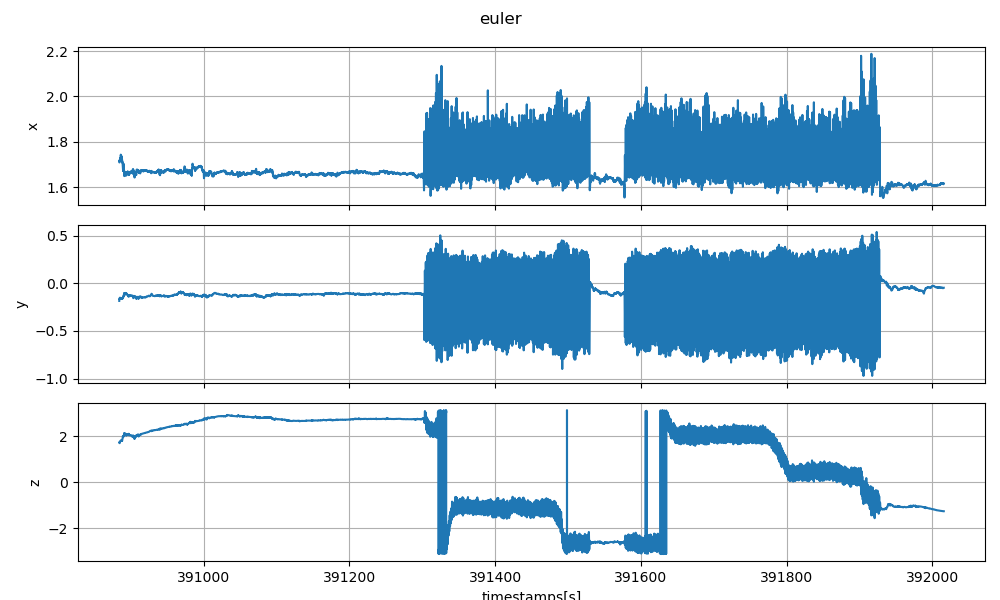

In [5]:
def vqf_cal(data, hz = 1 / frequence, tauAcc = 3):
  vqf = PyVQF(hz, tauAcc = tauAcc)
  # ENU -> NED
  enu2ned = ahrs.Quaternion([0, np.sqrt(2) / 2, np.sqrt(2) / 2, 0])
  index = np.shape(data[0])[0]
  Q = np.empty((index, 4))
  E = np.empty((index, 3))
  H = np.empty((index, 1))
  D = np.empty((index, 1), dtype = bool)
  for i in range(index):
    vqf.update(np.ascontiguousarray(data[4:7, i]), np.ascontiguousarray(data[1:4, i]))
    Q[i, :] = enu2ned@vqf.getQuat6D()
    E[i, :] = Quaternion(Q[i,0], Q[i,1], Q[i,2], Q[i,3]).to_euler(degrees = False)
    H[i, :] = vqf.getDelta()
    D[i] = vqf.getRestDetected()
  return Q, E, H, D, vqf

Q, E, H, D, vqf = vqf_cal(data_raw)

plot_signal(data_raw[0], E.transpose(), 'euler')

### Leveling

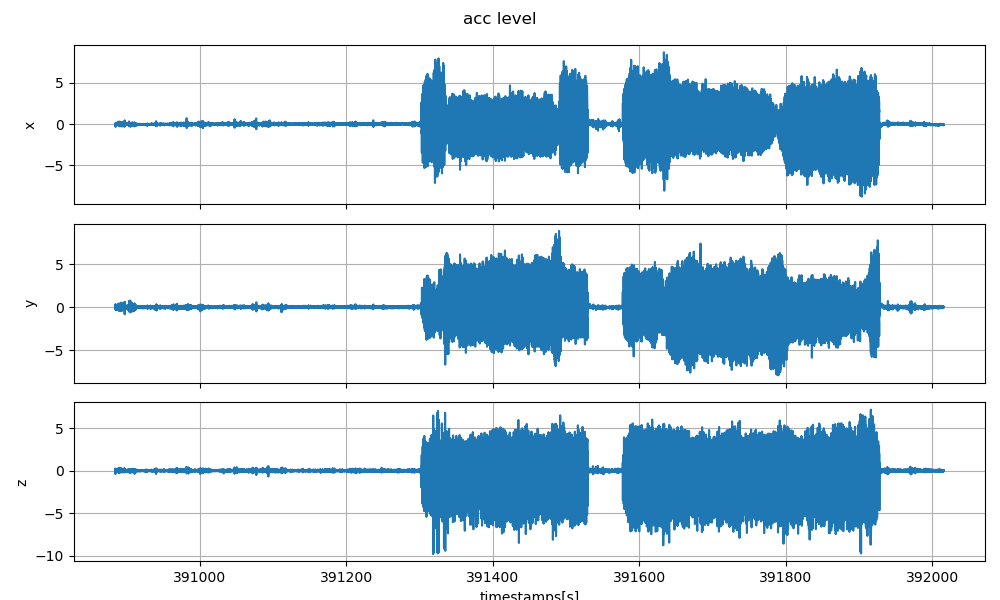

In [6]:
def transform_level(data, q):
  data_level = data.copy()
  for i in range(np.shape(data[0])[0]):
    R2 = np.array(Quaternion(q[i, 0], q[i, 1], q[i, 2], q[i, 3]).to_rot())
    data_level[1:4, i] = (np.dot(R2, data[1:4, i]))
    data_level[3, i] = data_level[3, i] + g
    data_level[4:7, i] = (np.dot(R2, data[4:7, i]))
  return data_level
data_raw_level = transform_level(data_raw, Q)
plot_signal(data_raw_level[0], data_raw_level[1:4], 'acc level')

## Step Detection
### Band-Pass Filter

In [7]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y
acc_D = butter_bandpass_filter(data_raw_level[3], 0.5, 3, frequence, order=2)

### Find Peaks

904


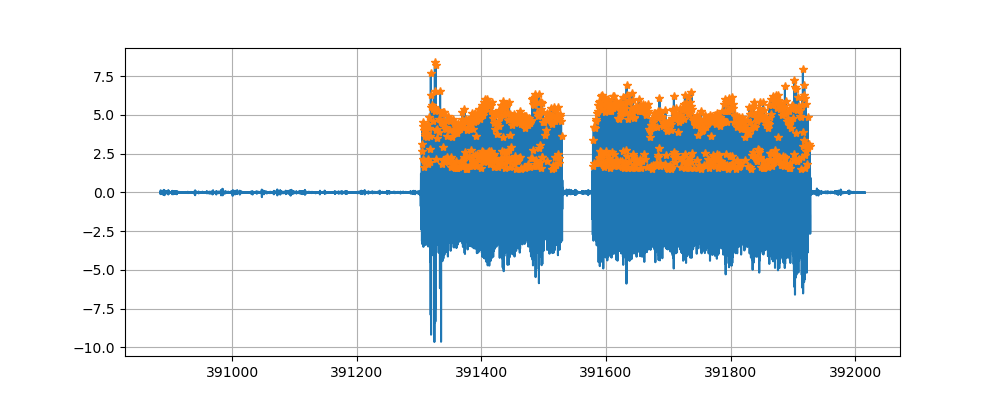

In [8]:
peaks, _ = find_peaks(acc_D , height=1.5, width=4)
fig = plt.figure(figsize = (10, 4))
plt.plot(data_raw_level[0], acc_D )
plt.plot(data_raw_level[0][peaks], acc_D[peaks], "*")
plt.grid()
print(np.shape(peaks)[0])

## Step Length Estimation

empirical : 599.0402926622262 m


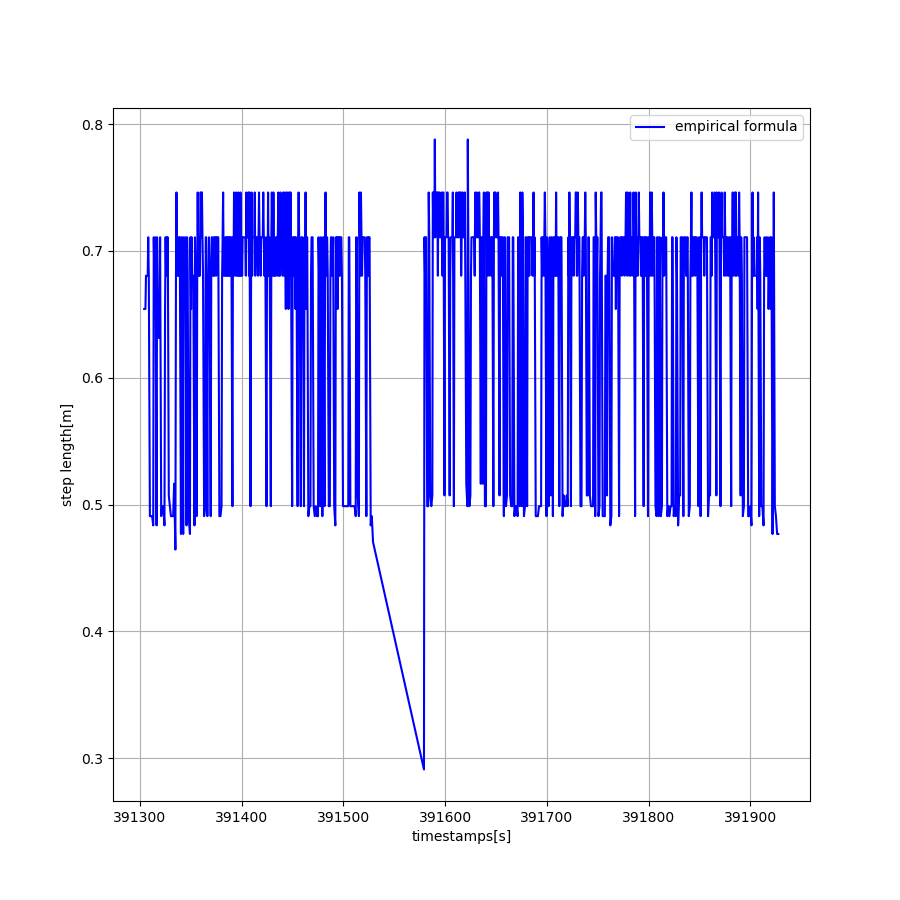

In [9]:
period = np.empty(np.shape(peaks)[0])
for i in range(np.shape(peaks)[0] - 1):
    period[i + 1]=(peaks[i + 1] - peaks[i]) / frequence
period[0] = period[1]
SF = 1 / period
step = 0.7 + 0.371 * (user_height - 1.75) + 0.227 * ((SF - 1.79) * user_height / 1.75)
speed = step * SF
fig = plt.figure(figsize = (9, 9))

plt.plot(data_raw_level[0][peaks], step, color='b', label = 'empirical formula')
plt.legend()
plt.grid()
plt.xlabel("timestamps[s]")
plt.ylabel("step length[m]")
distance1=np.sum(step)
print("empirical : "+ str(distance1) + " m")

## Heading Filtering

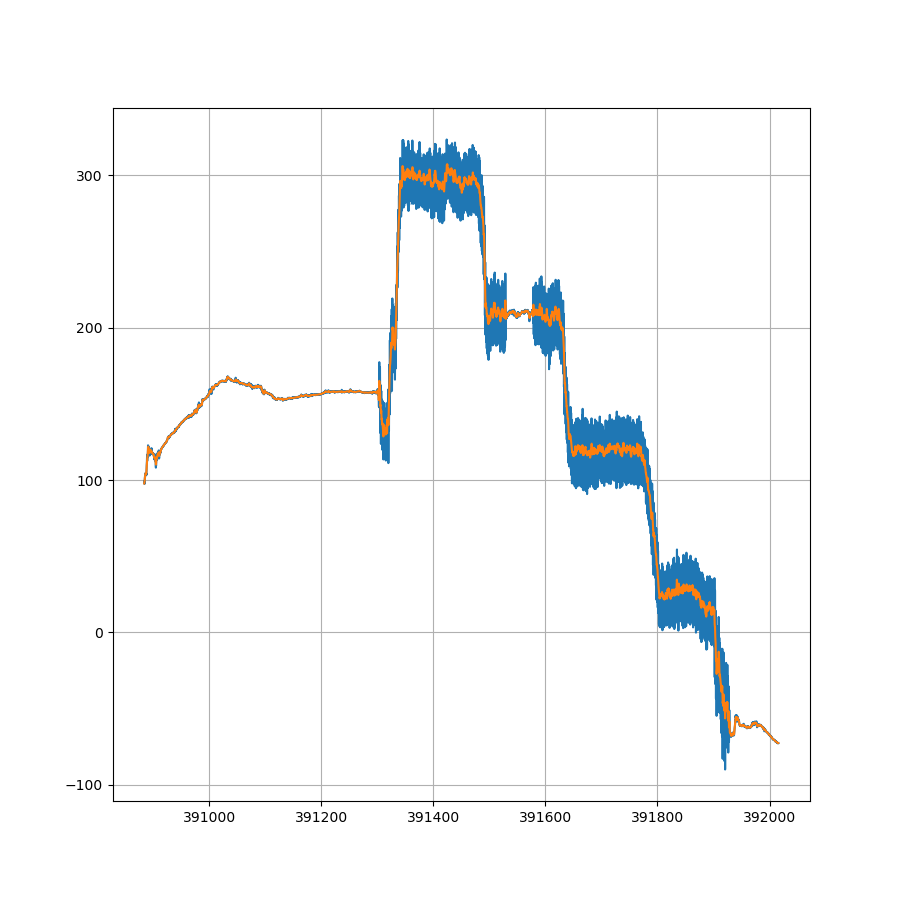

In [10]:
heading=np.deg2rad(savgol_filter(np.unwrap(np.rad2deg(E.transpose()[2]), period=360), int(frequence * 1 + 1), 1))

fig = plt.figure(figsize = (9, 9))
plt.plot(data_raw_level[0], np.unwrap(np.rad2deg(E.transpose()[2]), period=360), data_raw_level[0], np.rad2deg(heading))
plt.grid()

## PDR

In [11]:
position=np.empty([np.shape(data_raw_level[0])[0], 2])
position[0, 0] = init_E
position[0, 1] = init_N
heading = heading - heading[0] + np.rad2deg(init_heading)
j=0
step_len = 0
for i in range(1, np.shape(data_raw_level[0])[0]):
    if  j + 1 < np.shape(peaks)[0] and i == peaks[j]:
        position[i, 0] = position[i - 1, 0] + step[j - 1] * np.sin(heading[i - 1])
        position[i, 1] = position[i - 1, 1] + step[j - 1] * np.cos(heading[i - 1])
        step_len += step[j - 1]
        j += 1
    else:
        position[i, 0] = position[i - 1, 0]
        position[i, 1] = position[i - 1, 1]

print("Total Length : " + str(step_len) + " m")

Total Length : 598.5634647114886 m


## Result
### Plot Trajectory

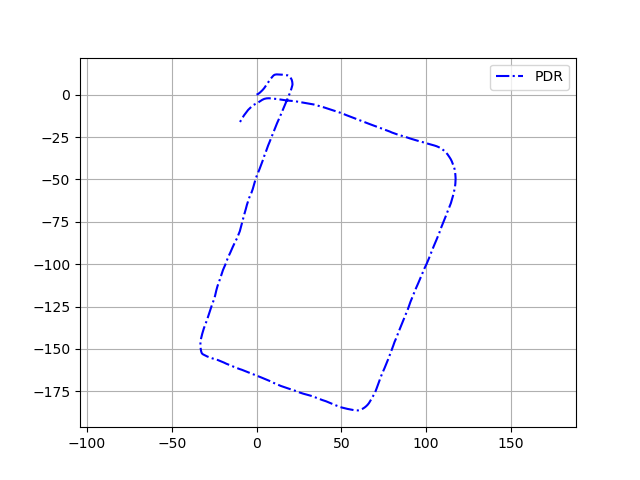

In [12]:
fig,ax=plt.subplots()
ax.plot(position[:, 0], position[:, 1], '-.', color = 'b', label = 'PDR')
ax.grid()
ax.legend()
plt.axis("equal")
plt.show()

### Export Result

In [13]:
traj = {
    "time": data_raw_level[0],
    "pdr_x": position[:, 0],
    "pdr_y": position[:, 1]
}

traj_result = pd.DataFrame(traj)
traj_result.to_csv(config['DATA_Path']['data_folder'] + config['DATA_Path']['output_name'], index=False)
traj_result

,time,pdr_x,pdr_y
0,390884.272,0.00000,0.000000
1,390884.312,0.00000,0.000000
2,390884.352,0.00000,0.000000
3,390884.392,0.00000,0.000000
4,390884.432,0.00000,0.000000
...,...,...,...
28305,392015.345,-10.33079,-17.008742
28306,392015.385,-10.33079,-17.008742
28307,392015.425,-10.33079,-17.008742
28308,392015.464,-10.33079,-17.008742
